## An analysis of evolutionary data of finches scandens and fortis.  

This is a Jupyter notebook redux of my own take on a case study from a DataCamp.com course on Statistical Thinking, Part 2.
It showcases the following: Graphical and quantitative EDA, parameter estimation, confidence interval calculation & hypothesis testing.  

### Original data publication:  

Grant, PR, Grant, BR (2014) 40 years of evolution:  
    Darwin's finches on Daphne Major Island.  
    Princeton: Princeton University Press. https://doi.org/  

Dryad data package:  

Grant PR, Grant BR (2014) Data from: 40 years of evolution.  
Darwin's finches on Daphne Major Island.  
Dryad Digital Repository. https://doi.org/10.5061/dryad.g6g3h  

### Importing and cleaning data from CSV files

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

finches_1975 = pd.read_csv('datasets/finch_beaks_1975.csv',
                           usecols=['species',
                                    'Beak length, mm',
                                    'Beak depth, mm'])
finches_1975.rename(columns={'Beak depth, mm': 'bdepth',
                             'Beak length, mm': 'blength'}, inplace=True)
finches_1975['year'] = 1975

finches_2012 = pd.read_csv('datasets/finch_beaks_2012.csv',
                           usecols=['species',
                                    'blength',
                                    'bdepth'])
finches_2012['year'] = 2012

finches = pd.concat([finches_1975, finches_2012], ignore_index=True)

### Perform an exploratory data analysis (EDA) of beak depth for G. scandens 1975 vs. 2012

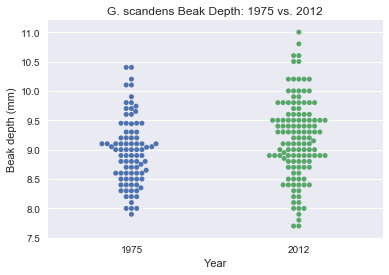

In [2]:
sns.set()  # Set Seaborn default plot style

# Isolating scandens beak depth, bdepth
y = finches.loc[finches['species'] == 'scandens', 'bdepth']
sns.swarmplot(x='year', y=y, data=finches)
plt.title('G. scandens Beak Depth: 1975 vs. 2012')
plt.xlabel('Year')
plt.ylabel('Beak depth (mm)');

In [3]:
# Function definitions


def ecdf(data):
    """
    Compute the empirical cumulative distribution function (ECDF)
    for a one-dimensional array of data.
    Params: data
    """

    n = len(data)  # Number of data points
    x = np.sort(data)
    y = np.arange(1, n+1) / n

    return x, y


def draw_bs_reps(data, func, size=1):
    """
    Draw bootstrap replicates for a given size and apply Numpy functions.
    Params: data, func, size
    """

    bs_replicates = np.empty(size)

    for i in range(size):
        bs_replicates[i] = func(np.random.choice(data, size=len(data)))

    return bs_replicates


def draw_bs_pairs_linreg(x, y, size=1):
    """
    Perform pairs bootstrap for linear regression.
    Params: x-data, y-data, size
    """

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps

Compute and plot the emperical cumulative distribution fuction (ECFD) of G. scandens beak measurements.  

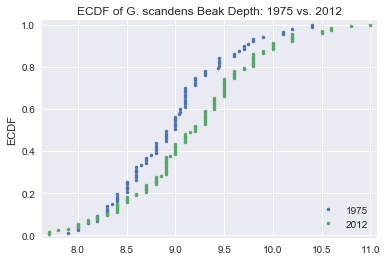

In [4]:
# Convert dataframes data to arrays for computation
bd_1975 = np.array(finches.loc[(finches['species'] == 'scandens') &
                               (finches['year'] == 1975),
                               'bdepth'])
bd_2012 = np.array(finches.loc[(finches['species'] == 'scandens') &
                               (finches['year'] == 2012),
                               'bdepth'])
x_1975, y_1975 = ecdf(bd_1975)
x_2012, y_2012 = ecdf(bd_2012)

plt.plot(x_1975, y_1975, marker='.', linestyle='none')
plt.plot(x_2012, y_2012, marker='.', linestyle='none')
plt.margins(0.02)
plt.title('ECDF of G. scandens Beak Depth: 1975 vs. 2012')
plt.ylabel('ECDF')
plt.legend(('1975', '2012'), loc='lower right');

### Parameter estimation of the mean difference between 1975 and 2012 data.  
A random seed value of seed(42) is used for reproducibility.  
For bootstrap data, a sample of 10,000 tries is used.  
The results are then compared to the 95% confidence interval.  

In [5]:
np.random.seed(42)

mean_diff = np.mean(bd_2012) - np.mean(bd_1975)

bs_replicates_1975 = draw_bs_reps(bd_1975, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(bd_2012, np.mean, 10000)

bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975
conf_int = np.percentile(bs_diff_replicates, [2.5, 97.5])

print('Difference of means =', mean_diff, 'mm')
print('95% confidence interval =', conf_int, 'mm')

Difference of means = 0.22622047244094645 mm
95% confidence interval = [0.05633521 0.39190544] mm


A result of 0.2 mm difference between the means of 2012 and 1975 is observed.  
This result lies between the 95% confidence interval of 0.05 to 0.38 mm.

## Hypothesis test: Are beaks deeper in 2012?

### Null hypothesis: The means of 2012 and 1975 are equal.  
-is this observation just due to random chance  
-what is the probability that one would observe the same or greater difference
 in mean beak depth if the means were the same (p-value)  

To perform this hypothesis test, the two data sets are shifted such that they have the same mean. Following that, a bootstrap sampling method of 10,000 samples is used to compute a new random difference of means.

In [6]:
combined_mean = np.mean(np.concatenate((bd_1975, bd_2012)))

bd_1975_shifted = bd_1975 - np.mean(bd_1975) + combined_mean
bd_2012_shifted = bd_2012 - np.mean(bd_2012) + combined_mean

bs_replicates_1975 = draw_bs_reps(bd_1975_shifted, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(bd_2012_shifted, np.mean, 10000)

bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

p = np.sum(bs_diff_replicates >= mean_diff) / len(bs_diff_replicates)

print('P-value of hypothesis test: p =', p)

P-value of hypothesis test: p = 0.0037


A p-value of 0.0037 is calculated, which suggests that there is a
statistically significant difference and the null hypotheses can be rejected.  
Combining this with the difference of 0.2 mm between the means suggest
a change by 0.2 mm in 37 years (1975 to 2012).

## EDA of beak length and depth  
The beak length and depth are compared to determine if there exists a correlation.

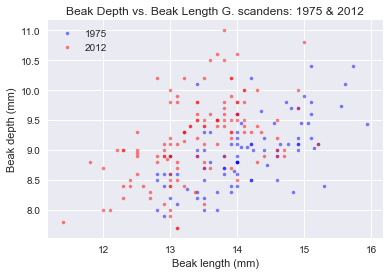

In [7]:
# Extracting beak length (blength) from original Data Frame
bl_1975 = np.array(finches.loc[(finches['species'] == 'scandens') &
                               (finches['year'] == 1975),
                               'blength'])
bl_2012 = np.array(finches.loc[(finches['species'] == 'scandens') &
                               (finches['year'] == 2012),
                               'blength'])

# Make scatter plots of 1975 & 2012 data
plt.figure(3)

plt.plot(bl_1975, bd_1975, marker='.',
         linestyle='none', color='blue', alpha=0.5)

plt.plot(bl_2012, bd_2012, marker='.',
         linestyle='none', color='red', alpha=0.5)

plt.title('Beak Depth vs. Beak Length G. scandens: 1975 & 2012')
plt.xlabel('Beak length (mm)')
plt.ylabel('Beak depth (mm)')
plt.legend(('1975', '2012'), loc='upper left');

From the plot, we see that beaks got deeper but not much longer.  

## Perform a linear regression of the beak length and depth  
First, the linear regressions of 1975 and 2012 data are computed.
Then a paris bootstrap sampling of 1000 linear gresressions is perfromed.
Following that, the 95% confidence interval of the bootstrap linear regression solpes and intercepts are dertermined.

In [8]:
slope_1975, intercept_1975 = np.polyfit(bl_1975, bd_1975, 1)
slope_2012, intercept_2012 = np.polyfit(bl_2012, bd_2012, 1)

bs_slope_reps_1975, bs_intercept_reps_1975 = \
        draw_bs_pairs_linreg(bl_1975, bd_1975, 1000)
bs_slope_reps_2012, bs_intercept_reps_2012 = \
        draw_bs_pairs_linreg(bl_2012, bd_2012, 1000)

slope_conf_int_1975 = np.percentile(bs_slope_reps_1975, [2.5, 97.5])
slope_conf_int_2012 = np.percentile(bs_slope_reps_2012, [2.5, 97.5])
intercept_conf_int_1975 = np.percentile(bs_intercept_reps_1975, [2.5, 97.5])
intercept_conf_int_2012 = np.percentile(bs_intercept_reps_2012, [2.5, 97.5])

print('1975: slope =', slope_1975,
      '95% conf int =', slope_conf_int_1975)
print('1975: intercept =', intercept_1975,
      '95% conf int =', intercept_conf_int_1975)
print('2012: slope =', slope_2012,
      '95% conf int =', slope_conf_int_2012)
print('2012: intercept =', intercept_2012,
      '95% conf int =', intercept_conf_int_2012)

1975: slope = 0.4652051691605937 95% conf int = [0.32895048 0.59051248]
1975: intercept = 2.3908752365842263 95% conf int = [0.56980654 4.32921979]
2012: slope = 0.462630358835313 95% conf int = [0.33013404 0.5971864 ]
2012: intercept = 2.9772474982360198 95% conf int = [1.15904983 4.74841692]


The linear regression data is then plotted.  

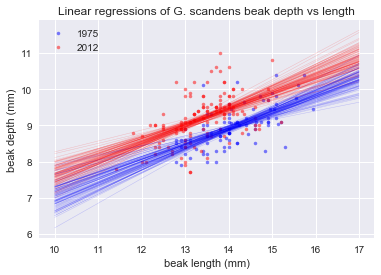

In [9]:
plt.plot(bl_1975, bd_1975, marker='.',
         linestyle='none', color='blue', alpha=0.5)

plt.plot(bl_2012, bd_2012, marker='.',
         linestyle='none', color='red', alpha=0.5)

plt.title('Linear regressions of G. scandens beak depth vs length')
plt.xlabel('beak length (mm)')
plt.ylabel('beak depth (mm)')
plt.legend(('1975', '2012'), loc='upper left')

# Generate x-values for bootstrap line plots
x = np.array([10, 17])

# Plot the bootstrap lines
for i in range(100):
    plt.plot(x, bs_slope_reps_1975[i] * x + bs_intercept_reps_1975[i],
             linewidth=0.5, alpha=0.2, color='blue')
    plt.plot(x, bs_slope_reps_2012[i] * x + bs_intercept_reps_2012[i],
             linewidth=0.5, alpha=0.2, color='red')

## Exploring the beak length and depth ratio  
The beak length and depth are copared to see how the values changed together. Firstly, the original data is compared, then a bootstrap sampling of 10,000 is used to determine a 99% confidence interval.

In [10]:
ratio_1975 = bl_1975 / bd_1975
ratio_2012 = bl_2012 / bd_2012

mean_ratio_1975 = np.mean(ratio_1975)
mean_ratio_2012 = np.mean(ratio_2012)

# Generate bootstrap replicates of the means for 10,000 samples
bs_replicates_1975 = draw_bs_reps(ratio_1975, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(ratio_2012, np.mean, 10000)

# Compute the 99% confidence intervals
conf_int_1975 = np.percentile(bs_replicates_1975, [0.5, 99.5])
conf_int_2012 = np.percentile(bs_replicates_2012, [0.5, 99.5])

print('1975: mean ratio =', mean_ratio_1975,
      '99% conf int =', conf_int_1975)
print('2012: mean ratio =', mean_ratio_2012,
      '99% conf int =', conf_int_2012)

1975: mean ratio = 1.5788823771858533 99% conf int = [1.55651998 1.60112118]
2012: mean ratio = 1.4658342276847767 99% conf int = [1.4448795  1.48772402]


The mean beak length-to-depth ratio decreased by about 0.1 from 1975 to 2012.
The 99% confidence intervals are not overlapping, which indicates that the beak shape changed.